In [1]:
###Import Packages###
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from skimage import io, color

import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

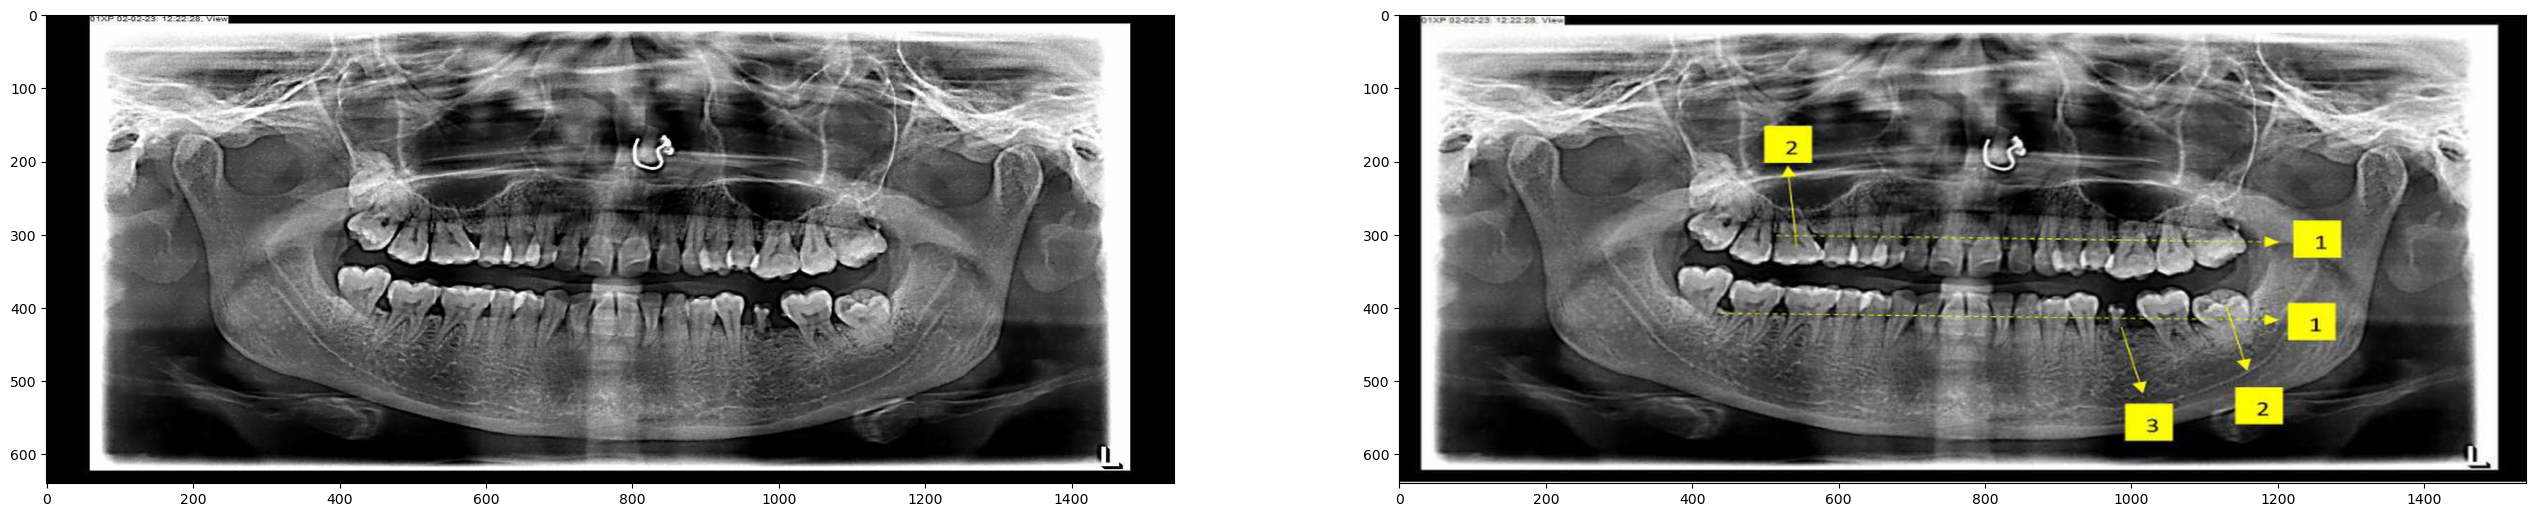

In [2]:
###Functions for Pre-Process DATA###
def convert_one_channel(img):
    #some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img

def pre_images(resize_shape,path):
    img=Image.open(path)
    img=img.resize((resize_shape),Image.ANTIALIAS)
    img=convert_one_channel(np.asarray(img))
    cv2.imwrite(path,img)
    return img

def resize(resize_shape,path):
    img=Image.open(path)
    # w,h=np.array(img).shape
    # print(w,h)
      # print(img.size)
    img=img.resize((resize_shape),Image.ANTIALIAS)
    return img

# for index in range(10):
#   pre_images((512,512),os.path.join('/content/d/Images', str(index+1)+'.png'))
ress1 = Image.open('/Users/shikarichacha/Desktop/CNN/X/1.jpg')
ress2 = Image.open('/Users/shikarichacha/Desktop/CNN/Y/1.jpg')
img1 = ress1.resize((1540, 640), Image.LANCZOS)
img2 = ress2.resize((1540, 640), Image.LANCZOS)

fig = plt.figure(figsize = (32,32))
ax = fig.add_subplot(2, 2, 1) 
plt.imshow(img1)
ax = fig.add_subplot(2, 2, 2) 
plt.imshow(img2)
plt.show()

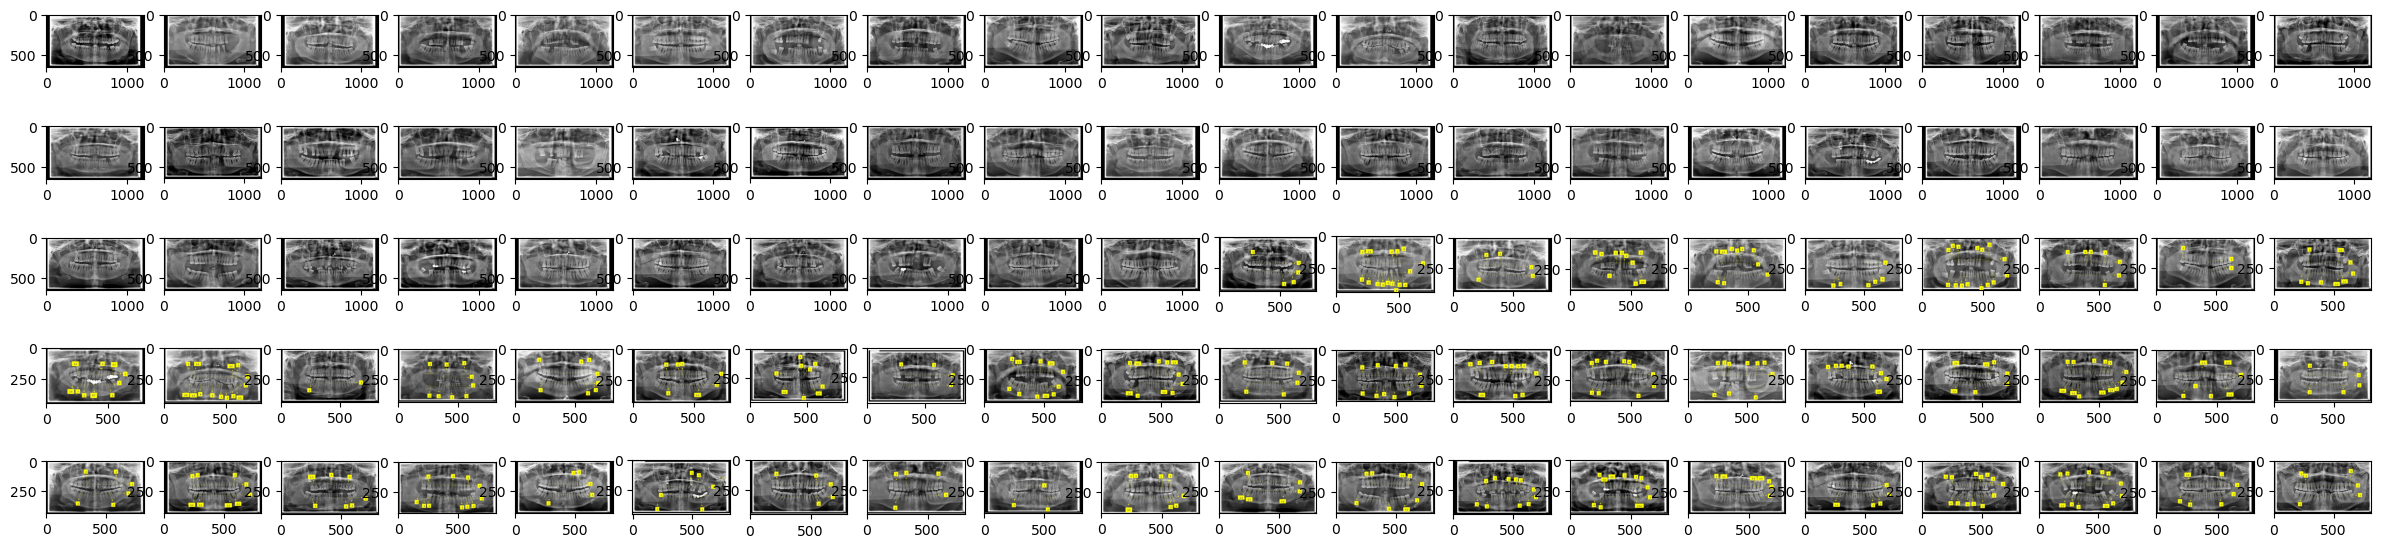

In [3]:
fig = plt.figure(figsize=(30, 7))
for index in range(50):
    file_path1 = os.path.join('/Users/shikarichacha/Desktop/CNN/X', str(index + 1) + '.jpg')
    file_path2 = os.path.join('/Users/shikarichacha/Desktop/CNN/Y', str(index + 1) + '.jpg')

    ax = fig.add_subplot(5, 20, index + 1)
    img1 = Image.open(file_path1)
    plt.imshow(img1)
    
    ax = fig.add_subplot(5, 20, index + 51)
    img2 = Image.open(file_path2)
    plt.imshow(img2)

plt.show()


In [4]:
# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

In [5]:
# Define the Runet Model
class Runet(nn.Module):
    def __init__(self):
        super(Runet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.res_blocks = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64)
        )
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv2 = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.res_blocks(x)
        x = self.upsample(x)
        x = self.conv2(x)
        return x

In [6]:
# Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir_X, root_dir_Y, transform=None):
        self.root_dir_X = root_dir_X
        self.root_dir_Y = root_dir_Y
        self.transform = transform
        self.images_X = os.listdir(root_dir_X)
        self.images_Y = os.listdir(root_dir_Y)

    def __len__(self):
        return len(self.images_X)

    def __getitem__(self, idx):
        img_name_X = os.path.join(self.root_dir_X, self.images_X[idx])
        img_name_Y = os.path.join(self.root_dir_Y, self.images_Y[idx])
        image_X = Image.open(img_name_X).convert('RGB')
        image_Y = Image.open(img_name_Y).convert('RGB')
        if self.transform:
            image_X = self.transform(image_X)
            image_Y = self.transform(image_Y)
        return image_X, image_Y

In [7]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

In [8]:
# Create the dataset
dataset = CustomDataset(root_dir_X='/Users/shikarichacha/Desktop/CNN/X', root_dir_Y='/Users/shikarichacha/Desktop/CNN/Y', transform=transform)

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
dataset
data_loader

NameError: name 'data_loader' is not defined

# Initialize the model
model = Runet()
model


In [9]:
model = Runet() 
model

Runet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer




In [ ]:
# Upsample the target tensor to match the size of the input tensor
upsampled_images_Y = F.interpolate(images_Y, size=(256, 256), mode='bilinear', align_corners=False)

# Calculate the loss using the upsampled target tensor
loss = criterion(outputs, upsampled_images_Y)


In [ ]:
# Train the model
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images_X, images_Y) in enumerate(dataloader, 0):
        optimizer.zero_grad()
        outputs = model(images_X)
        
        # Upsample the target tensor to match the size of the input tensor
        upsampled_images_Y = F.interpolate(images_Y, size=(256, 256), mode='bilinear', align_corners=False)
        
        # Calculate the loss using the upsampled target tensor
        loss = criterion(outputs, upsampled_images_Y)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")

print("Finished Training")


In [ ]:
# Define the path to save the model
model_path = "/Users/shikarichacha/Desktop/CNN/model.pth"

# Save the model
torch.save(model.state_dict(), model_path)



In [ ]:
from runet_model import Runet  # Import the Runet class from the runet_model module

Runet_model = Runet()  # Create an instance of the Runet model
validation_accuracy = calculate_accuracy(Runet_model, validation_loader)
print(f"Validation Accuracy: {validation_accuracy}")



# Test model

In [10]:
# Load your trained model
model = Runet()
model.load_state_dict(torch.load('/Users/shikarichacha/Desktop/CNN/model.pth'))
model.eval()


Runet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace

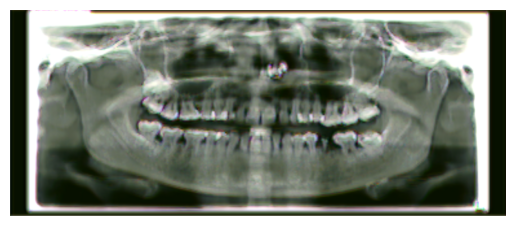

In [11]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = "/Users/shikarichacha/Desktop/CNN/X/1.jpg"
img = Image.open(img_path)
img = img.resize((1540, 640), Image.LANCZOS)  # Resize to match your model input size
if img.mode != "RGB":
    img = img.convert("RGB")  # Convert to RGB if not already
img = np.asarray(img) / 255.0  # Normalize the image

# Convert the image to a numpy array and add a batch dimension
img = np.expand_dims(img, axis=0)

# Convert the numpy array to a PyTorch tensor
img = torch.tensor(img, dtype=torch.float32).permute(0, 3, 1, 2)  # Change the channel position

# Pass the image through your model
model.eval()
with torch.no_grad():
    output = model(img)

# Post-process the output as needed
# For example, you can convert it to a numpy array and visualize it
output = output.squeeze().permute(1, 2, 0).numpy()  # Change the channel position back

# Clip the output to the valid range for display
output = np.clip(output, 0, 1)

# Visualize the output
plt.imshow(output)
plt.axis('off')
plt.show()


Predicted Label: [[2 2 2 ... 2 2 2]
 [2 2 0 ... 2 2 2]
 [2 0 0 ... 2 2 2]
 ...
 [1 1 1 ... 1 2 2]
 [1 1 1 ... 1 1 2]
 [1 1 1 ... 1 1 1]]
Ground Truth Label: 1


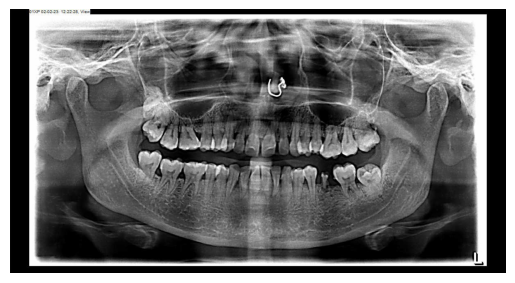

Accuracy: 0.2398741883116883


In [15]:
import torch
from PIL import Image
from torchvision import transforms

# Load the trained model
model_path = "/Users/shikarichacha/Desktop/CNN/model.pth"
model = Runet()
model.load_state_dict(torch.load(model_path))
model.eval()

# Prepare a test image
image_path = "/Users/shikarichacha/Desktop/CNN/X/1.jpg"
img = Image.open(image_path)

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((640, 1540)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img = transform(img).unsqueeze(0)

# Perform inference
with torch.no_grad():
    output = model(img)

# Post-process the output as needed
# For example, you can convert it to a numpy array and visualize it
output = output.squeeze().numpy()

# Get the predicted label
predicted_label = output.argmax(axis=0)

# Assuming you have the ground truth label for the test image
ground_truth_label = 1  # Replace with the actual ground truth label

# Show the predicted and ground truth labels
print(f"Predicted Label: {predicted_label}")
print(f"Ground Truth Label: {ground_truth_label}")



img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()


# Assuming predicted_label and ground_truth_label are numpy arrays
accuracy = (predicted_label == ground_truth_label).mean()
print(f"Accuracy: {accuracy}")


In [16]:
# Calculate accuracy
accuracy = 1 if np.array_equal(predicted_label, ground_truth_label) else 0
print(f"Accuracy: {accuracy}")


Accuracy: 0
